In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

In [48]:
# Load the datasets
file_path = "nfl_data_with_team_stats.csv"
nfl_data = pd.read_csv(file_path)

In [49]:
nfl_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7242 entries, 0 to 7241
Data columns (total 69 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   schedule_date          7242 non-null   object 
 1   schedule_season        7242 non-null   int64  
 2   schedule_week          7242 non-null   object 
 3   schedule_playoff       7242 non-null   bool   
 4   team_home              7242 non-null   object 
 5   score_home             7242 non-null   int64  
 6   score_away             7242 non-null   int64  
 7   team_away              7242 non-null   object 
 8   team_favorite_id       7242 non-null   object 
 9   spread_favorite        7242 non-null   float64
 10  over_under_line        7242 non-null   float64
 11  stadium                7242 non-null   object 
 12  stadium_neutral        7242 non-null   bool   
 13  weather_temperature    6094 non-null   float64
 14  weather_wind_mph       6086 non-null   float64
 15  weat

In [50]:
nfl_data

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,...,PTS/G_away_defense,OPP PTS_away_defense,PLAYS_away_defense,YDS_away_defense,YDS/PLAY_away_defense,1ST DWN_away_defense,PENALTY_away_defense,P YDS_away_defense,TOP_away_defense,+/- TOV_away_defense
0,1998-09-06,1998,1,False,Baltimore Ravens,13,20,Pittsburgh Steelers,PIT,-3.0,...,18.9,303,1002,4963,5.0,266,106,854,30:46:00,-2
1,1998-09-06,1998,1,False,Carolina Panthers,14,19,Atlanta Falcons,CAR,-4.5,...,18.1,289,949,4739,5.0,267,119,858,27:50:00,19
2,1998-09-06,1998,1,False,Chicago Bears,23,24,Jacksonville Jaguars,JAX,-10.0,...,21.1,338,1057,5558,5.3,313,109,953,31:01:00,10
3,1998-09-06,1998,1,False,Cincinnati Bengals,14,23,Tennessee Oilers,PICK,0.0,...,20.0,320,955,5123,5.4,280,93,704,28:20:00,0
4,1998-09-06,1998,1,False,Dallas Cowboys,38,10,Arizona Cardinals,DAL,-5.5,...,23.6,378,1048,5260,5.0,321,115,956,31:51:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7237,2025-01-19,2024,Division,True,Buffalo Bills,27,25,Baltimore Ravens,BAL,-1.5,...,20.5,41,104,553,5.3,31,8,51,26:06:00,-3
7238,2025-01-19,2024,Division,True,Philadelphia Eagles,28,22,Los Angeles Rams,PHI,-7.0,...,18.5,37,132,619,4.7,36,5,34,32:36:00,0
7239,2025-01-26,2024,Conference,True,Philadelphia Eagles,55,23,Washington Commanders,PHI,-6.0,...,35.3,106,178,1264,7.1,77,17,125,27:02:00,2
7240,2025-01-26,2024,Conference,True,Kansas City Chiefs,32,29,Buffalo Bills,KC,-1.0,...,21.3,64,162,1008,6.2,64,13,91,25:20:00,4


In [51]:
# Create backtesting windows
n_splits = 5  # Define the number of backtesting splits, 10 means each split cover 4-5 years
tscv = TimeSeriesSplit(n_splits=n_splits)

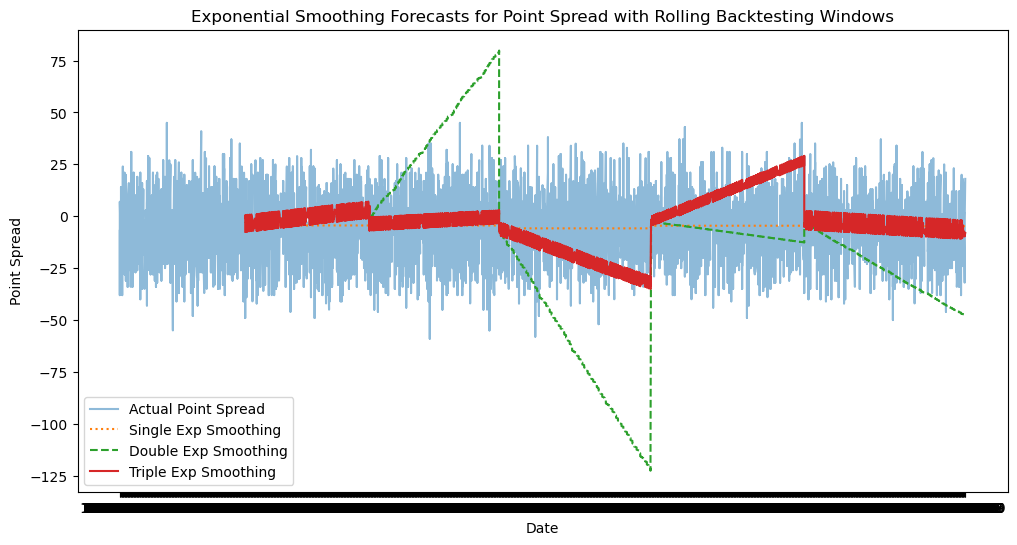

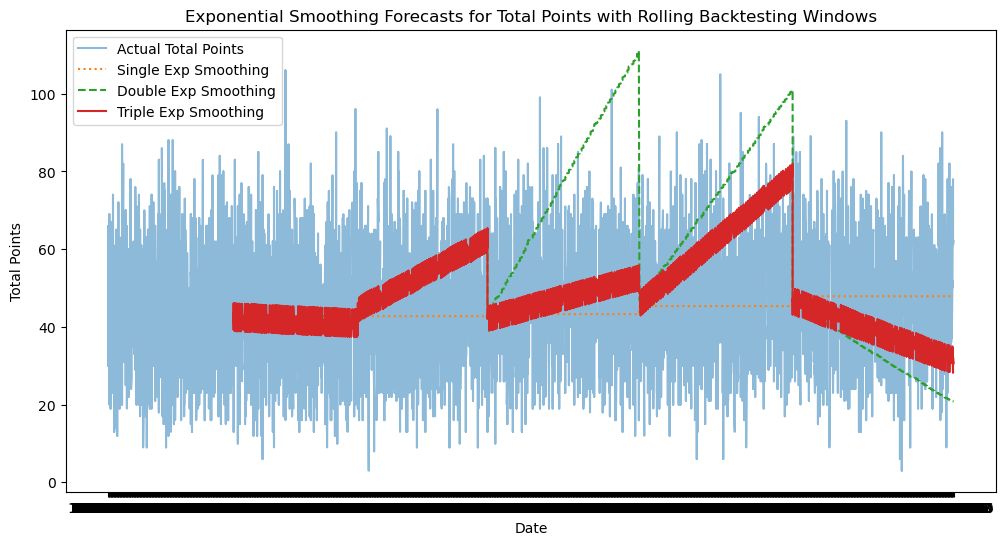

Average RMSE for actual_spread: {'single': 190.81008342437536, 'double': 1767.4345348244256, 'triple': 330.3699304743978}
Average MAE for actual_spread: {'single': 10.654901273034975, 'double': 30.327881225500278, 'triple': 14.228353776021208}
Average MAPE for actual_spread: {'single': inf, 'double': inf, 'triple': inf}
Average RMSE for actual_total_points: {'single': 198.42020815332685, 'double': 726.5390574525139, 'triple': 303.03780308888497}
Average MAE for actual_total_points: {'single': 11.148155504875632, 'double': 20.76659122324049, 'triple': 13.84490793930685}
Average MAPE for actual_total_points: {'single': 31.013242463567828, 'double': 57.15227911449123, 'triple': 39.33002648245657}


In [52]:
# Adjust seasonal period based on NFL season length
seasonal_period = 16  # Approximate number of games in an NFL season

# Apply ETS over rolling forecast approach for both point spread and total points
for target in ["actual_spread", "actual_total_points"]:
    nfl_data[f"{target}_single_exp"] = None
    nfl_data[f"{target}_double_exp"] = None
    nfl_data[f"{target}_triple_exp"] = None
    
    for train_index, test_index in tscv.split(nfl_data):
        train, test = nfl_data.iloc[train_index], nfl_data.iloc[test_index]
        
        # Apply Single, Double, and Triple Exponential Smoothing
        model_single = SimpleExpSmoothing(train[target]).fit()
        model_double = ExponentialSmoothing(train[target], trend='add').fit()
        model_triple = ExponentialSmoothing(train[target], trend='add', seasonal='add', seasonal_periods=seasonal_period).fit()
        
        nfl_data.loc[test.index, f"{target}_single_exp"] = model_single.forecast(len(test)).values
        nfl_data.loc[test.index, f"{target}_double_exp"] = model_double.forecast(len(test)).values
        nfl_data.loc[test.index, f"{target}_triple_exp"] = model_triple.forecast(len(test)).values

# Convert forecast columns to numeric type
for target in ["actual_spread", "actual_total_points"]:
    for method in ["single_exp", "double_exp", "triple_exp"]:
        nfl_data[f"{target}_{method}"] = pd.to_numeric(nfl_data[f"{target}_{method}"], errors="coerce")

# Plot ETS results as continuous forecast lines for both point spread and total points
for target, label in zip(["actual_spread", "actual_total_points"], ["Point Spread", "Total Points"]):
    plt.figure(figsize=(12, 6))
    plt.plot(nfl_data["schedule_date"], nfl_data[target], label=f"Actual {label}", alpha=0.5)
    plt.plot(nfl_data["schedule_date"], nfl_data[f"{target}_single_exp"], label="Single Exp Smoothing", linestyle='dotted')
    plt.plot(nfl_data["schedule_date"], nfl_data[f"{target}_double_exp"], label="Double Exp Smoothing", linestyle='dashed')
    plt.plot(nfl_data["schedule_date"], nfl_data[f"{target}_triple_exp"], label="Triple Exp Smoothing", linestyle='solid')
    
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.title(f"Exponential Smoothing Forecasts for {label} with Rolling Backtesting Windows")
    plt.legend()
    plt.show()

# Compute RMSE, MAE, and MAPE for both point spread and total points
metrics = {"rmse": mean_squared_error, "mae": mean_absolute_error, "mape": lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100}
for target in ["actual_spread", "actual_total_points"]:
    for metric_name, metric_func in metrics.items():
        scores = {"single": [], "double": [], "triple": []}
        
        for train_index, test_index in tscv.split(nfl_data):
            test = nfl_data.iloc[test_index]
            for method in ["single_exp", "double_exp", "triple_exp"]:
                scores[method.split('_')[0]].append(metric_func(test[target].values, test[f"{target}_{method}"].values))
        
        print(f"Average {metric_name.upper()} for {target}:", {key: np.mean(values) for key, values in scores.items()})

Average RMSE for spread_error: {'single': 176.33353697481516, 'double': 2551.925870431809, 'triple': 208.5123138165076}
Average MAE for spread_error: {'single': 10.305838644549258, 'double': 38.91239144390901, 'triple': 11.391601776834502}
Average MAPE for spread_error: {'single': inf, 'double': inf, 'triple': inf}
Average RMSE for total_points_error: {'single': 178.99396812881702, 'double': 1862.4797121348988, 'triple': 303.5785553582048}
Average MAE for total_points_error: {'single': 10.585385766566992, 'double': 32.03681981251534, 'triple': 13.821645665248345}
Average MAPE for total_points_error: {'single': inf, 'double': inf, 'triple': inf}
Average RMSE for underdog_won: {'single': 0.22392836339727054, 'double': 0.22429161790073, 'triple': 0.2255545833156291}
Average MAE for underdog_won: {'single': 0.45578140692209157, 'double': 0.45335303989923936, 'triple': 0.4526957507061554}
Average MAPE for underdog_won: {'single': inf, 'double': inf, 'triple': inf}
Average RMSE for over_hit:

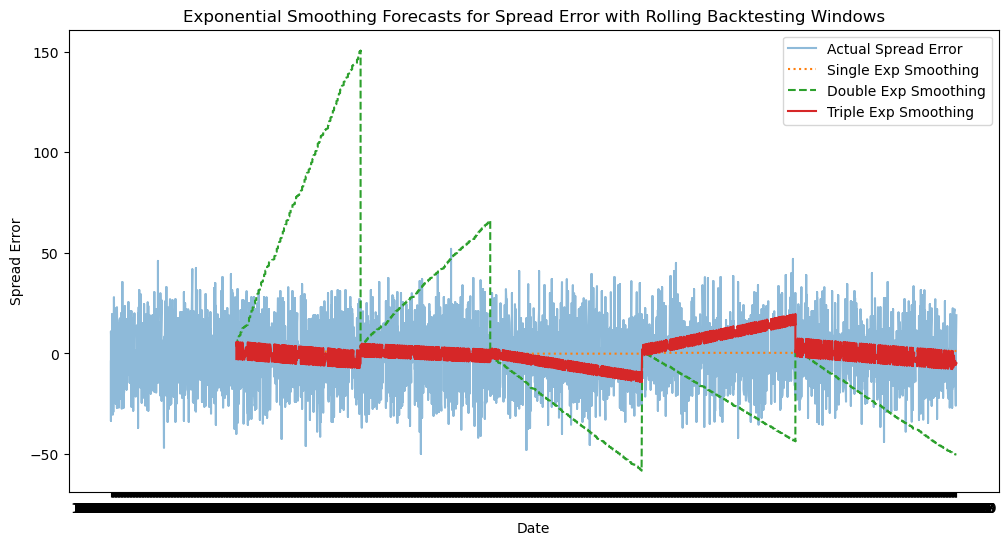

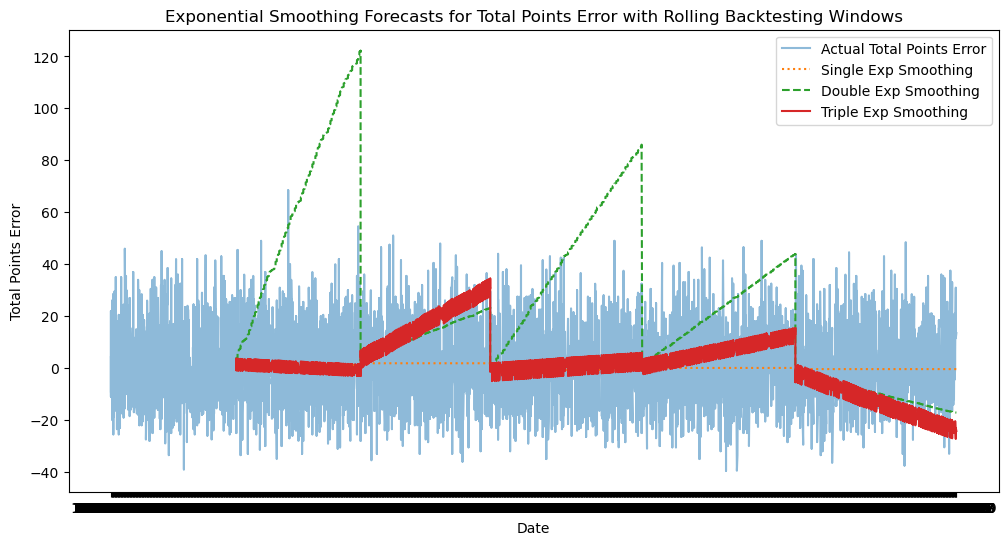

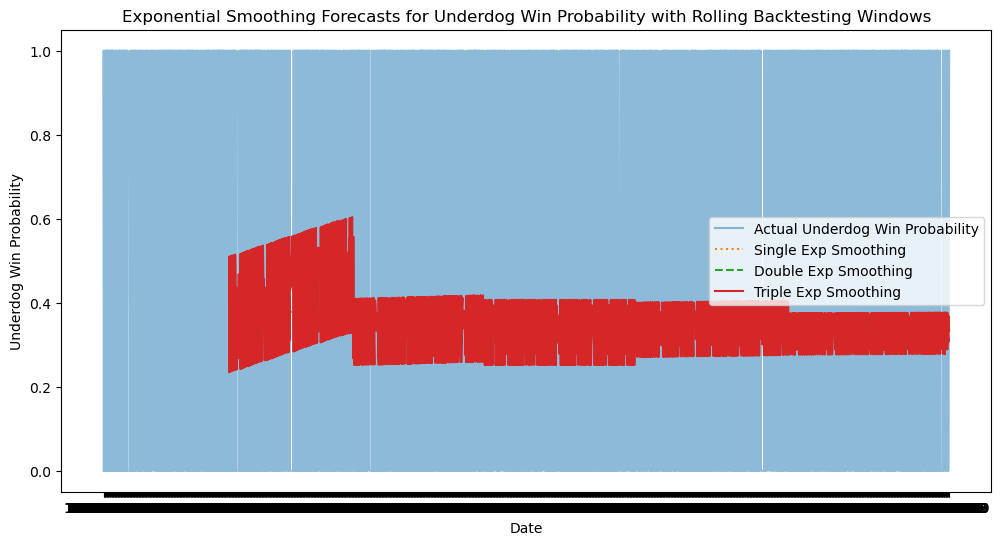

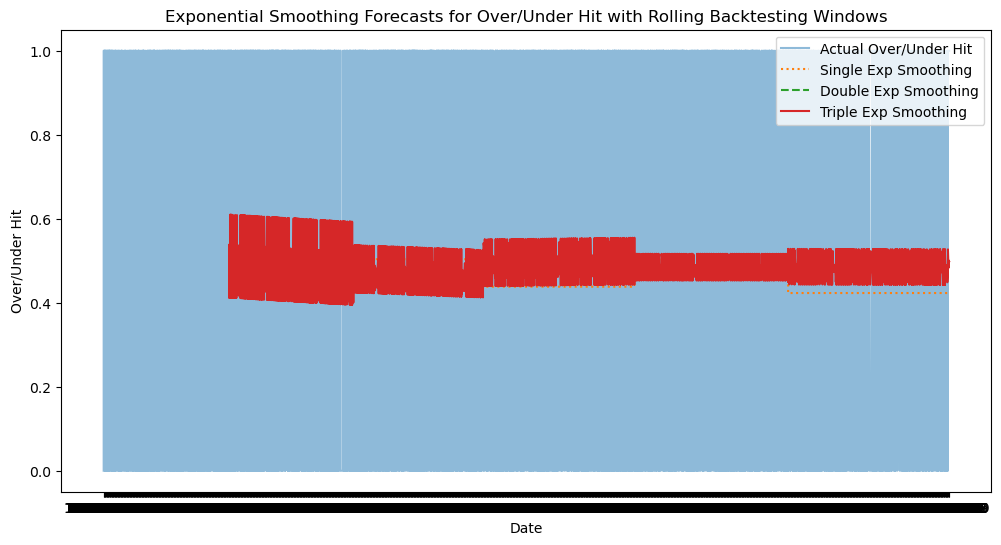

In [53]:
# Apply ETS over rolling forecast approach for spread error, total points error, and classification targets
for target in ["spread_error", "total_points_error", "underdog_won", "over_hit"]:
    nfl_data[f"{target}_single_exp"] = None
    nfl_data[f"{target}_double_exp"] = None
    nfl_data[f"{target}_triple_exp"] = None
    
    for train_index, test_index in tscv.split(nfl_data):
        train, test = nfl_data.iloc[train_index], nfl_data.iloc[test_index]
        
        # Apply Single, Double, and Triple Exponential Smoothing
        model_single = SimpleExpSmoothing(train[target]).fit()
        model_double = ExponentialSmoothing(train[target], trend='add').fit()
        model_triple = ExponentialSmoothing(train[target], trend='add', seasonal='add', seasonal_periods=seasonal_period).fit()
        
        nfl_data.loc[test.index, f"{target}_single_exp"] = model_single.forecast(len(test)).values
        nfl_data.loc[test.index, f"{target}_double_exp"] = model_double.forecast(len(test)).values
        nfl_data.loc[test.index, f"{target}_triple_exp"] = model_triple.forecast(len(test)).values

# Convert forecast columns to numeric type
for target in ["spread_error", "total_points_error", "underdog_won", "over_hit"]:
    for method in ["single_exp", "double_exp", "triple_exp"]:
        nfl_data[f"{target}_{method}"] = pd.to_numeric(nfl_data[f"{target}_{method}"], errors="coerce")

# Compute RMSE, MAE, and MAPE for error predictions
metrics = {
    "rmse": mean_squared_error,
    "mae": mean_absolute_error,
    "mape": lambda y, y_pred: np.mean(np.abs((y - y_pred) / y)) * 100
}
for target in ["spread_error", "total_points_error", "underdog_won", "over_hit"]:
    for metric_name, metric_func in metrics.items():
        scores = {"single": [], "double": [], "triple": []}
        
        for train_index, test_index in tscv.split(nfl_data):
            test = nfl_data.iloc[test_index]
            for method in ["single_exp", "double_exp", "triple_exp"]:
                scores[method.split('_')[0]].append(
                    metric_func(test[target].values, test[f"{target}_{method}"].values)
                )
        
        print(f"Average {metric_name.upper()} for {target}:", {key: np.mean(values) for key, values in scores.items()})

# Plot ETS forecast results
import matplotlib.pyplot as plt
for target, label in zip(
    ["spread_error", "total_points_error", "underdog_won", "over_hit"],
    ["Spread Error", "Total Points Error", "Underdog Win Probability", "Over/Under Hit"]
):
    plt.figure(figsize=(12, 6))
    plt.plot(nfl_data["schedule_date"], nfl_data[target], label=f"Actual {label}", alpha=0.5)
    plt.plot(nfl_data["schedule_date"], nfl_data[f"{target}_single_exp"], label="Single Exp Smoothing", linestyle='dotted')
    plt.plot(nfl_data["schedule_date"], nfl_data[f"{target}_double_exp"], label="Double Exp Smoothing", linestyle='dashed')
    plt.plot(nfl_data["schedule_date"], nfl_data[f"{target}_triple_exp"], label="Triple Exp Smoothing", linestyle='solid')
    
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.title(f"Exponential Smoothing Forecasts for {label} with Rolling Backtesting Windows")
    plt.legend()
    plt.show()


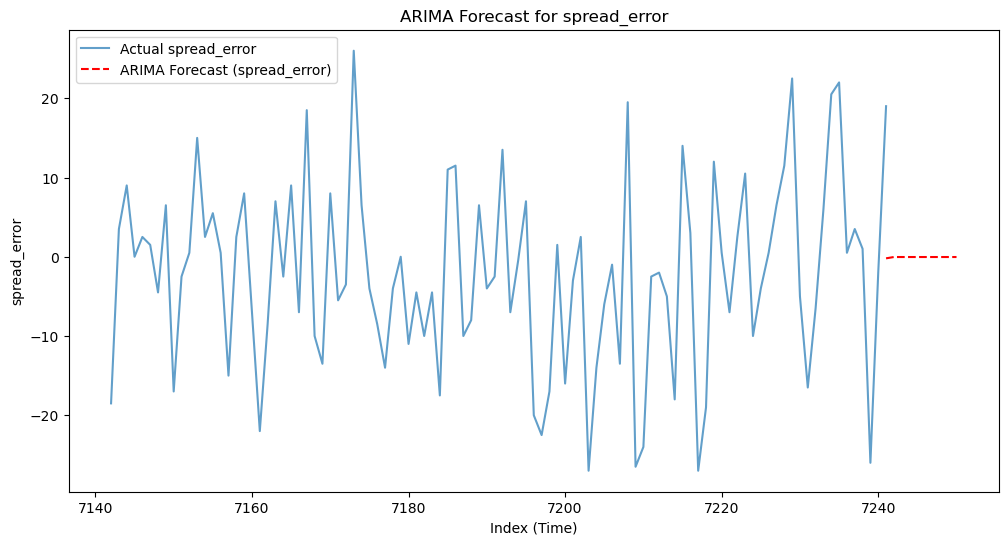

ARIMA Model Summary for spread_error:
                               SARIMAX Results                                
Dep. Variable:           spread_error   No. Observations:                 7242
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -28973.107
Date:                Tue, 18 Feb 2025   AIC                          57952.214
Time:                        00:29:28   BIC                          57972.876
Sample:                             0   HQIC                         57959.322
                               - 7242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0087      0.012     -0.735      0.462      -0.032       0.015
ma.L1         -1.0000      0.002   -445.266      0.000      -1.004      -0.996
sigma2       1

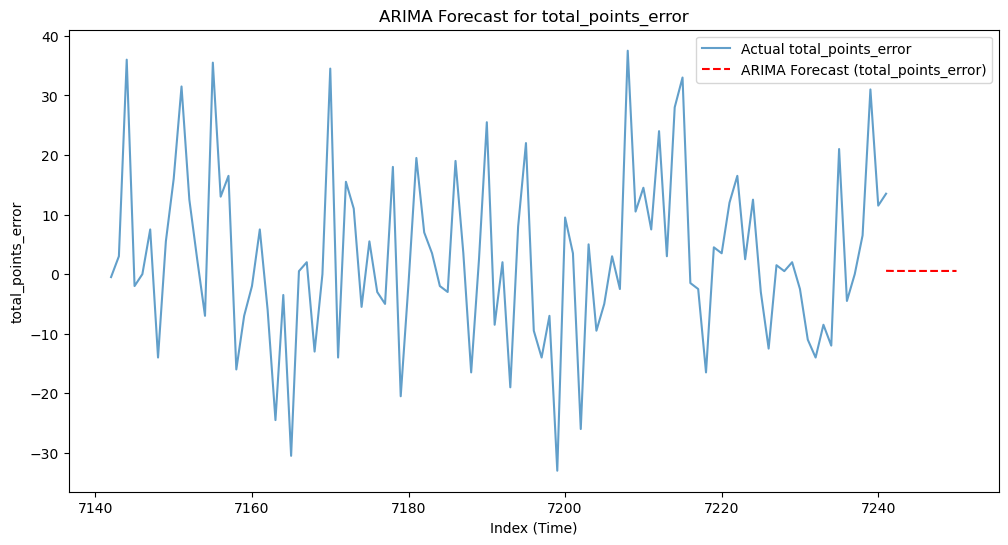

ARIMA Model Summary for total_points_error:
                               SARIMAX Results                                
Dep. Variable:     total_points_error   No. Observations:                 7242
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -29083.844
Date:                Tue, 18 Feb 2025   AIC                          58173.689
Time:                        00:29:29   BIC                          58194.351
Sample:                             0   HQIC                         58180.797
                               - 7242                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0017      0.012      0.144      0.885      -0.021       0.025
ma.L1         -0.9994      0.000  -2083.964      0.000      -1.000      -0.999
sigma2  

In [54]:
from statsmodels.tsa.arima.model import ARIMA

# Define function to apply ARIMA and forecast spread error and total points error
def apply_arima(target, order=(1,1,1), forecast_steps=10):
    """
    Fits an ARIMA model to the given target variable and plots forecast results.
    
    Parameters:
    - target: str, name of the target variable (e.g., "spread_error", "total_points_error").
    - order: tuple, ARIMA(p,d,q) order.
    - forecast_steps: int, number of future steps to forecast.
    """
    # Drop NA values (ARIMA can't handle missing data)
    df = nfl_data.dropna(subset=[target]).copy()
    
    # Fit ARIMA model
    model = ARIMA(df[target], order=order)
    fitted_model = model.fit()
    
    # Forecast future values
    forecast = fitted_model.forecast(steps=forecast_steps)
    
    # Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-100:], df[target].iloc[-100:], label=f"Actual {target}", alpha=0.7)
    plt.plot(range(df.index[-1], df.index[-1] + forecast_steps), forecast, label=f"ARIMA Forecast ({target})", linestyle='dashed', color='red')
    plt.xlabel("Index (Time)")
    plt.ylabel(target)
    plt.title(f"ARIMA Forecast for {target}")
    plt.legend()
    plt.show()
    
    # Print model summary
    print(f"ARIMA Model Summary for {target}:")
    print(fitted_model.summary())

# Apply ARIMA to spread error and total points error
apply_arima("spread_error")
apply_arima("total_points_error")

Accuracy for predicting underdog wins (no data leakage): 0.665


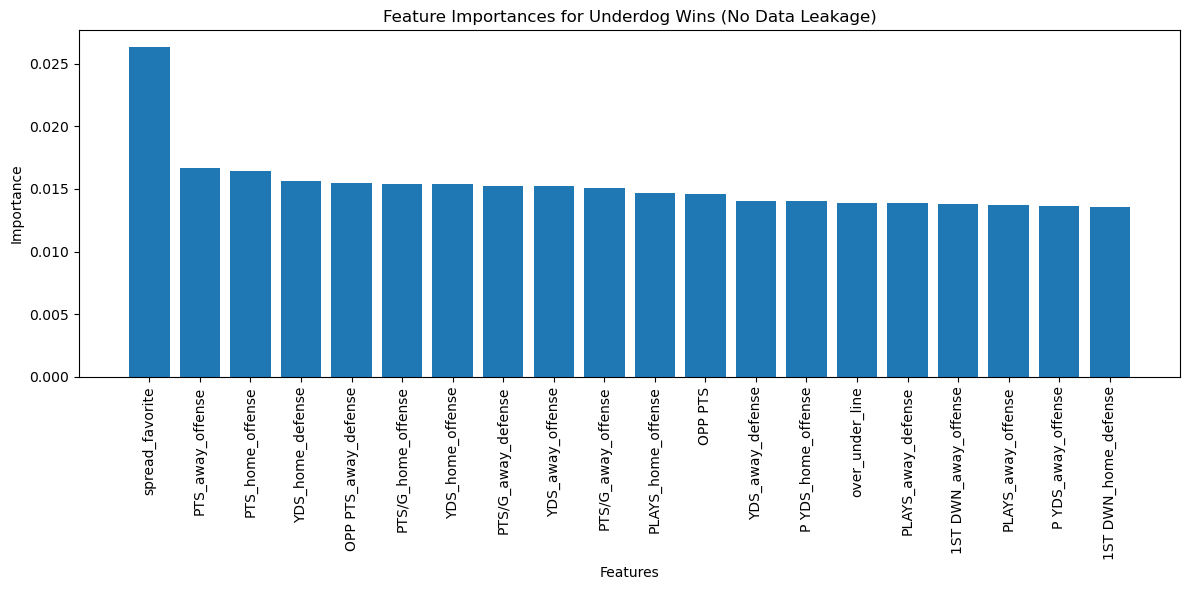

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Let's say 'nfl_data' is your DataFrame containing all columns.
# Our target is 'underdog_won'.

# Additional leaky columns to exclude
forecast_cols = [col for col in nfl_data.columns if (
    col.endswith("_single_exp") or
    col.endswith("_double_exp") or
    col.endswith("_triple_exp")
)]

# Combine them with the existing leaky columns
leaky_columns = [
    "actual_spread",
    "spread_error",
    "score_home",
    "score_away",
    "actual_total_points",
    "total_points_error",
    "over_hit",
    "underdog_won",
    "schedule_date"
] + forecast_cols

# 2. Build a feature set (X) by dropping these columns. Keep the target (y).
X = nfl_data.drop(columns=leaky_columns, errors='ignore')
y = nfl_data["underdog_won"]

# 3. Convert any categorical variables to numeric (via one-hot encoding).
X_encoded = pd.get_dummies(X, drop_first=True)

# 4. Split into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# 5. Train a Random Forest classifier (you could use any classifier).
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 6. Evaluate accuracy on the test set.
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy for predicting underdog wins (no data leakage): {accuracy:.3f}")

# 7. Plot feature importances.
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Decide how many top features you want to show
num_features_to_plot = 20  
top_indices = indices[:num_features_to_plot]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances for Underdog Wins (No Data Leakage)")
plt.bar(range(num_features_to_plot), importances[top_indices], align='center')
plt.xticks(range(num_features_to_plot), X_encoded.columns[top_indices], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()



Accuracy for predicting over hits (no data leakage): 0.546


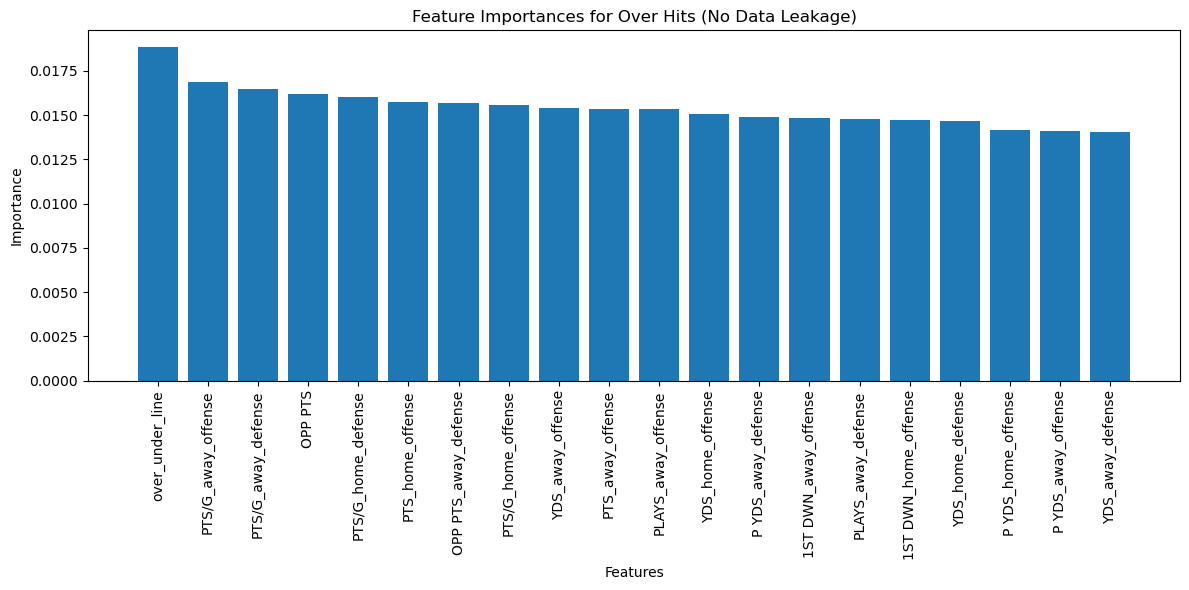

In [56]:
# 1. Define columns that leak outcome information for over_hit.
leaky_columns_overhit = [
    "score_home",           # Final home score
    "score_away",           # Final away score
    "actual_total_points",  # Derived from final scores
    "total_points_error",   # Derived from final scores
    "actual_spread",        # Also derived from final scores
    "spread_error",         # Also derived from final scores
    "underdog_won",         # Another target (not necessarily leaking for over_hit, but not needed)
    "over_hit",             # This is our target
    "schedule_date"         # Typically not used for predictive modeling
] + forecast_cols

# 2. Build a feature set (X) by dropping these columns. Keep the target (y).
X_overhit = nfl_data.drop(columns=leaky_columns_overhit, errors='ignore')
y_overhit = nfl_data["over_hit"]

# 3. Convert any categorical variables to numeric (via one-hot encoding).
X_overhit_encoded = pd.get_dummies(X_overhit, drop_first=True)

# 4. Split into training and testing sets.
X_train_oh, X_test_oh, y_train_oh, y_test_oh = train_test_split(
    X_overhit_encoded, 
    y_overhit, 
    test_size=0.3, 
    random_state=42
)

# 5. Train a Random Forest classifier (you could use any classifier).
rf_overhit = RandomForestClassifier(random_state=42)
rf_overhit.fit(X_train_oh, y_train_oh)

# 6. Evaluate accuracy on the test set.
y_pred_oh = rf_overhit.predict(X_test_oh)
accuracy_oh = accuracy_score(y_test_oh, y_pred_oh)
print(f"Accuracy for predicting over hits (no data leakage): {accuracy_oh:.3f}")

# 7. Plot feature importances.
importances_oh = rf_overhit.feature_importances_
indices_oh = np.argsort(importances_oh)[::-1]

num_features_to_plot = 20
top_indices_oh = indices_oh[:num_features_to_plot]

plt.figure(figsize=(12, 6))
plt.title("Feature Importances for Over Hits (No Data Leakage)")
plt.bar(range(num_features_to_plot), importances_oh[top_indices_oh], align='center')
plt.xticks(range(num_features_to_plot), X_overhit_encoded.columns[top_indices_oh], rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [57]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ---------------------------
# 1. Prepare the Data
# ---------------------------
# Define columns that leak post-game information.
leaky_columns = [
    "score_home",         # Final home score
    "score_away",         # Final away score
    "actual_spread",      # Derived from final scores
    "spread_error",       # Derived from final scores
    "actual_total_points",# Derived from final scores
    "total_points_error", # Derived from final scores
    "schedule_date"       # Not used as a predictive feature
] + forecast_cols

# Set the target variable (choose "underdog_won" or "over_hit")
target_variable = "underdog_won"
# If you want to predict over hits instead, change to: target_variable = "over_hit"

# Drop leaky columns and the target from the feature set.
X = nfl_data.drop(columns=leaky_columns + [target_variable], errors='ignore')
y = nfl_data[target_variable]

# One-hot encode categorical variables.
X = pd.get_dummies(X, drop_first=True)

# Combine features and target, then drop rows with any missing values.
data = pd.concat([X, y], axis=1)
data = data.dropna()  # Drop any row with missing values.

# Separate back into features and target.
X = data.drop(columns=[target_variable])
y = data[target_variable]

# ---------------------------
# 2. Split the Data
# ---------------------------
# Stratified split to maintain target proportions.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ---------------------------
# 3. Define Model Pipelines
# ---------------------------
# For models that benefit from scaling, include a scaler.
pipelines = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
    ])
}

# ---------------------------
# 4. Cross-Validation for Model Comparison
# ---------------------------
scoring = ["accuracy", "precision", "recall", "f1"]
cv_results = {}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, pipeline in pipelines.items():
    scores = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
    cv_results[name] = {metric: np.mean(scores[f"test_{metric}"]) for metric in scoring}

# Display the average CV metrics for each model.
print("Cross-Validation Results:")
for model_name, metrics_dict in cv_results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics_dict.items():
        print(f"  {metric}: {value:.3f}")

# ---------------------------
# 5. Train on Training Data and Evaluate on Test Set
# ---------------------------
print("\nTest Set Evaluation:")
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))



Cross-Validation Results:

Logistic Regression:
  accuracy: 0.571
  precision: 0.362
  recall: 0.394
  f1: 0.377

Random Forest:
  accuracy: 0.657
  precision: 0.418
  recall: 0.100
  f1: 0.161

SVM:
  accuracy: 0.655
  precision: 0.371
  recall: 0.058
  f1: 0.100

XGBoost:
  accuracy: 0.636
  precision: 0.428
  recall: 0.290
  f1: 0.345

Test Set Evaluation:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0      0.689     0.696     0.693       626
           1      0.373     0.365     0.369       310

    accuracy                          0.587       936
   macro avg      0.531     0.531     0.531       936
weighted avg      0.584     0.587     0.585       936


Random Forest Classification Report:
              precision    recall  f1-score   support

           0      0.682     0.935     0.788       626
           1      0.474     0.119     0.191       310

    accuracy                          0.665       936
   macro av

In [58]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE  # Imbalanced-learn package
from imblearn.pipeline import Pipeline as ImbPipeline

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# ---------------------------
# 1. Prepare the Data (drop leaky features, one-hot encode, drop missing rows)
# ---------------------------
leaky_columns = [
    "score_home", "score_away", "actual_spread", "spread_error",
    "actual_total_points", "total_points_error", "schedule_date"
] + forecast_cols

# Choose target: "underdog_won"
target_variable = "underdog_won"

X = nfl_data.drop(columns=leaky_columns + [target_variable], errors='ignore')
y = nfl_data[target_variable]

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

# Save the list of training features (this is what the model sees)
training_features = X.columns.tolist()
print("Training features:")
print(training_features)

# Combine X and y then drop rows with missing values
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns=[target_variable])
y = data[target_variable]

# ---------------------------
# 2. Split the Data
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ---------------------------
# 3. Define Pipelines with SMOTE and Class Weights
# ---------------------------
pipelines = {
    "Logistic Regression": ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    "Random Forest": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
    ]),
    "SVM": ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('clf', SVC(class_weight='balanced', probability=True, random_state=42))
    ]),
    "XGBoost": ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('clf', XGBClassifier(use_label_encoder=False, eval_metric="logloss", 
                                scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
                                random_state=42))
    ])
}

# ---------------------------
# 4. Cross-Validation with Updated Pipelines
# ---------------------------
scoring = ["accuracy", "precision", "recall", "f1"]
cv_results = {}
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for name, pipeline in pipelines.items():
    scores = cross_validate(pipeline, X_train, y_train, cv=skf, scoring=scoring)
    cv_results[name] = {metric: np.mean(scores[f"test_{metric}"]) for metric in scoring}

print("Cross-Validation Results with SMOTE and Class Weights:")
for model_name, metrics_dict in cv_results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics_dict.items():
        print(f"  {metric}: {value:.3f}")

# ---------------------------
# 5. Train on Training Data and Evaluate on Test Set
# ---------------------------
print("\nTest Set Evaluation with SMOTE and Class Weights:")
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    
# (Assuming XGBoost performed best, you can later save or directly use the XGBoost pipeline)
model_underdog = pipelines["XGBoost"]


Training features:
['schedule_season', 'schedule_playoff', 'spread_favorite', 'over_under_line', 'stadium_neutral', 'weather_temperature', 'weather_wind_mph', 'weather_humidity', 'over_hit', 'RK_home_offense', 'PTS/G_home_offense', 'PTS_home_offense', 'PLAYS_home_offense', 'YDS_home_offense', 'YDS/PLAY_home_offense', '1ST DWN_home_offense', 'PENALTY_home_offense', 'P YDS_home_offense', '+/- TOV_home_offense', 'RK_away_offense', 'PTS/G_away_offense', 'PTS_away_offense', 'PLAYS_away_offense', 'YDS_away_offense', 'YDS/PLAY_away_offense', '1ST DWN_away_offense', 'PENALTY_away_offense', 'P YDS_away_offense', '+/- TOV_away_offense', 'RK_home_defense', 'PTS/G_home_defense', 'OPP PTS', 'PLAYS_home_defense', 'YDS_home_defense', 'YDS/PLAY_home_defense', '1ST DWN_home_defense', 'PENALTY_home_defense', 'P YDS_home_defense', '+/- TOV_home_defense', 'RK_away_defense', 'PTS/G_away_defense', 'OPP PTS_away_defense', 'PLAYS_away_defense', 'YDS_away_defense', 'YDS/PLAY_away_defense', '1ST DWN_away_defens

In [78]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import ipywidgets as widgets
from IPython.display import display

# Load data
df = pd.read_csv("nfl_data_with_team_stats.csv")

# Drop columns that would be known post-game
drop_cols = [
    "score_home", "score_away", "spread_error", "total_points_error",
    "underdog_won", "over_hit"
]
df.drop(columns=drop_cols, inplace=True)

# Drop rows with missing weather data
weather_cols = ["weather_temperature", "weather_wind_mph", "weather_humidity"]
df.dropna(subset=weather_cols, inplace=True)

# Convert Time of Possession (TOP) from MM:SS:00 or MM:SS to total seconds
def convert_time_to_seconds(time_str):
    if isinstance(time_str, str) and ":" in time_str:
        time_str = time_str.rstrip(":00")  # Remove ":00" if present
        parts = time_str.split(":")
        if len(parts) == 2:  # MM:SS format
            m, s = map(int, parts)
            return m * 60 + s
        elif len(parts) == 3:  # HH:MM:SS format
            h, m, s = map(int, parts)
            return h * 3600 + m * 60 + s
    return np.nan  # Return NaN if invalid

top_cols = ["TOP_home_offense", "TOP_away_offense", "TOP_home_defense", "TOP_away_defense"]
for col in top_cols:
    df[col] = df[col].apply(convert_time_to_seconds)

# Combine both home and away teams to ensure all teams are included
all_teams = pd.concat([df["team_home"], df["team_away"]]).unique()

# Fit the LabelEncoder on all unique teams
team_encoder = LabelEncoder()
team_encoder.fit(all_teams)

# Transform both home and away teams
df["team_home"] = team_encoder.transform(df["team_home"])
df["team_away"] = team_encoder.transform(df["team_away"])

# Save mapping for decoding later
team_mapping = dict(zip(team_encoder.classes_, team_encoder.transform(team_encoder.classes_)))

# Convert schedule_date to datetime features
df["schedule_date"] = pd.to_datetime(df["schedule_date"])
df["schedule_month"] = df["schedule_date"].dt.month
df["schedule_day"] = df["schedule_date"].dt.day
df.drop(columns=["schedule_date"], inplace=True)

# Convert categorical features to numeric
categorical_cols = ["schedule_week", "team_favorite_id", "stadium", "weather_detail", "team_home_id", "team_away_id"]
for col in categorical_cols:
    df[col] = df[col].astype("category").cat.codes

# Define targets
target_spread = "actual_spread"
target_total_points = "actual_total_points"

# Prepare feature matrix and targets
X = df.drop(columns=[target_spread, target_total_points])
y_spread = df[target_spread]
y_total_points = df[target_total_points]

# Train/test split
X_train, X_test, y_train_spread, y_test_spread = train_test_split(X, y_spread, test_size=0.2, random_state=42)
X_train, X_test, y_train_total, y_test_total = train_test_split(X, y_total_points, test_size=0.2, random_state=42)

# Train XGBoost models
spread_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05, max_depth=6, enable_categorical=True)
spread_model.fit(X_train, y_train_spread)

total_points_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05, max_depth=6, enable_categorical=True)
total_points_model.fit(X_train, y_train_total)

# Save the trained models
spread_model.save_model("spread_model.json")
total_points_model.save_model("total_points_model.json")

# Get original team names (not encoded)
teams = sorted(team_mapping.keys())

# Create Dropdown Widgets for Team Selection
team_home_dropdown = widgets.Dropdown(
    options=teams,
    description="Home Team:",
    style={'description_width': 'initial'}
)

team_away_dropdown = widgets.Dropdown(
    options=teams,
    description="Away Team:",
    style={'description_width': 'initial'}
)

favored_team_dropdown = widgets.Dropdown(
    options=teams,
    description="Favored Team:",
    style={'description_width': 'initial'}
)

# Create Input Boxes for Predicted Spread and Over/Under
predicted_spread_input = widgets.FloatText(
    value=0.0,
    description="Sportsbook Spread:",
    style={'description_width': 'initial'}
)

predicted_ou_input = widgets.FloatText(
    value=45.0,
    description="Sportsbook Over/Under:",
    style={'description_width': 'initial'}
)

# Display Inputs
display(team_home_dropdown, team_away_dropdown, favored_team_dropdown, predicted_spread_input, predicted_ou_input)

# Button to Trigger Prediction
predict_button = widgets.Button(description="Predict Outcomes")
display(predict_button)

def calculate_probability(error, scale=5):
    return 1 / (1 + np.exp(error / scale))

def make_predictions(b):
    team_home = team_home_dropdown.value
    team_away = team_away_dropdown.value
    favored_team = favored_team_dropdown.value
    predicted_spread = predicted_spread_input.value
    predicted_ou = predicted_ou_input.value

    underdog_team = team_home if favored_team == team_away else team_away

    team_home_encoded = team_mapping[team_home]
    team_away_encoded = team_mapping[team_away]

    game_data = df[(df["team_home"] == team_home_encoded) & (df["team_away"] == team_away_encoded)].iloc[-1:]

    if game_data.empty:
        print("\n❌ No historical matchups found between these teams.")
    else:
        X_input = game_data.drop(columns=[target_spread, target_total_points], errors="ignore")
        spread_model.load_model("spread_model.json")
        total_points_model.load_model("total_points_model.json")
        predicted_actual_spread = spread_model.predict(X_input)[0]
        predicted_actual_total_points = total_points_model.predict(X_input)[0]
        
        spread_error = predicted_actual_spread - predicted_spread
        ou_error = predicted_actual_total_points - predicted_ou
        spread_prob = calculate_probability(spread_error)
        ou_prob = calculate_probability(ou_error)
        
        if predicted_actual_spread < 0:
            print(f"🏈 The model predicts that the {favored_team} will win by {abs(predicted_actual_spread):.2f} points. (Prob: {spread_prob:.2%})")
            print("✅ Recommended Bet: Bet on the favored team to cover the spread." if abs(predicted_actual_spread) > abs(predicted_spread) else "✅ Recommended Bet: Favored team wins, but does not cover the spread.")
        else:
            print(f"🏈 The model predicts that the {underdog_team} will win by {predicted_actual_spread:.2f} points. (Prob: {spread_prob:.2%})")
            print("✅ Recommended Bet: Bet on the underdog to win outright.")
        print(f"🏈 Predicted Total Points: {predicted_actual_total_points:.2f} (Prob: {ou_prob:.2%})")
        print("✅ Recommended Bet: Bet on the over." if predicted_actual_total_points > predicted_ou else "✅ Recommended Bet: Bet on the under.")

# Ensure button is connected to function
predict_button.on_click(make_predictions)


Dropdown(description='Home Team:', options=('Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens', 'Buffa…

Dropdown(description='Away Team:', options=('Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens', 'Buffa…

Dropdown(description='Favored Team:', options=('Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens', 'Bu…

FloatText(value=0.0, description='Sportsbook Spread:', style=DescriptionStyle(description_width='initial'))

FloatText(value=45.0, description='Sportsbook Over/Under:', style=DescriptionStyle(description_width='initial'…

Button(description='Predict Outcomes', style=ButtonStyle())

🏈 The model predicts that the Dallas Cowboys will win by 4.98 points. (Prob: 47.39%)
✅ Recommended Bet: Favored team wins, but does not cover the spread.
🏈 Predicted Total Points: 55.47 (Prob: 27.03%)
✅ Recommended Bet: Bet on the over.
